#### Copyright 2017 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Lab 2: Training Your First TF Linear Regression Model


**Learning Objectives:**
* Use pyplot to help visualize the data, the learned model, and how the loss is evolving during training
* Learn how to set up the features in TensorFlow to train a model.
* Use the `LinearRegressor` class in TensorFlow to predict a real-valued featured based on one real-valued input feature
* Visualize the resulting model using pyplot
* Evaluate the accuracy of a model's predictions using Root Mean Squared Error (RMSE)
* Improve the accuracy of a model by tuning the learning rate and number of training steps

There are a lot of things introduced in this lab so carefully look through what is provided and ask if you have questions. Much of what is here will be used throughout this course without the need to modify them.  Others, we will slowly modify as needed to handle the complexities that arise in real-world learning problems.

## Data Set
This lab will use a data set from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets) under [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).  You can find a description of the data at [https://archive.ics.uci.edu/ml/datasets/automobile](https://archive.ics.uci.edu/ml/datasets/automobile). 

## Imports and basic set-up
As in the last lab, we'll import some libraries and set up some options for Pandas.

In [3]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

## Load and randomizing the data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). When using SGD (stochastic graident descent) for training it is important that **each batch is a random sample of the data** so that the gradient computed is representative.  While there appears to be no order to this data set, it is always good practice to shuffle the data to be in a random order.


In [4]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')

# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

## Converting missing numerical values to the column mean

When training a linear model using numerical features, we cannot have missing entries or NaN (doing so would cause overflow when training). Here we replace NaN (which corresponding to where we had missing entries) by the column mean.

In [5]:
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')

# Replace nan by the mean storing the solution in the same table (`inplace')
car_data.fillna(car_data.mean(), inplace=True)
car_data.describe()


,symboling,wheel-base,length,width,height,weight,engine-size,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,104.26,5125.37,25.22,30.75,13207.13
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,3.97,39.52,476.98,6.54,6.89,7868.77
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,48.00,4150.00,13.00,16.00,5118.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,70.00,4800.00,19.00,25.00,7788.00
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,95.00,5200.00,24.00,30.00,10595.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,116.00,5500.00,30.00,34.00,16500.00
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,288.00,6600.00,49.00,54.00,45400.00


## Setting Up the Feature Columns for TensorFlow
In order to train a model in TensorFlow there is some set-up that will be needed each time. Each feature that you want to use for training will be put in what is called a feature column.  There are two kinds of basic data that you will use.

*  ** Categorical Data** - This is data that is textual, for example `fuel-type` and `num-doors`
*   **Numerical Data** - This is data that is a number (integer or float) that you want to treat as a number.  As we will discuss more later, sometimes you might want to treat numerical data (e.g., a zipcode) as if it were categorical.

The first thing we will do is create a list of these type of features.  It is okay, as seen below, if one of these lists is empty.  In fact, we won't introduce any categorical data until a few labs later.

In [6]:
CATEGORICAL_COLUMNS = []
NUMERICAL_COLUMNS = ["price", "horsepower", "city-mpg", "highway-mpg",
                     "peak-rpm", "compression-ratio"]

## Input Function
This next code block is some of the most complex code that will be provided. Please try to understand it the best you can.  However, you will not need to modify this so don't worry if you are confused a bit by it.


The `input_fn` sets up a dictionary (hash map) needed to include numerical and categorical columns and assign each feature column to a unique integer id.

In [7]:
def input_fn(dataframe):
  """Constructs a dictionary for the feature columns

  Args:
    dataframe: The Pandas dataframe to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creates a dictionary mapping from each numeric feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values)
                     for k in NUMERICAL_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(list(numerical_cols.items()) + list(categorical_cols.items()))
  # Converts the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returns the feature columns and the label.
  return feature_cols, label

## Specialize the Input Function for Training
We will want to have different versions of the input function based on which dataset
they are using.  For this lab we will just need a single input function
(`train_input_fn`) that uses the training data.

In [8]:
def train_input_fn():
  """Sets up the input function using the training data.

  Returns:
     The feature columns to use for training and the associated labels.
  """
  return input_fn(training_examples)

##Prepare Features
As our learning models get more sophisticated we will want to do some computation on the features and even generate new features from the existing features. We will see examples of this in later labs.  For now this method will just make a copy of a portion of the dataframe.

In [9]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  return processed_features

##Generate the Training Examples
We simple call `prepare_features` on the `car_data` dataframe.

In [10]:
training_examples = prepare_features(car_data)

##Define the Numerical Feature Columns for TensorFlow

We use [`tf.contrib.layers.real_valued_column`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/real_valued_column) to define each column of numerical data.  We will introduce categorical data in a later lab.

In [11]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns
  """
  feature_set = set([tf.contrib.layers.real_valued_column(feature) 
                     for feature in NUMERICAL_FEATURES])
  return feature_set


## Setting up TensorFlow for Training a Basic Linear Regression Model


The learning model we will use is [`tf.contrib.learn.LinearRegressor`](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/LinearRegressor).
provided by the TensorFlow [`contrib.learn`](https://www.tensorflow.org/get_started/tflearn) library. This library helps make it easy to many things such as using Pandas columns as features, interacting with data, training models, and computing the predictions from a trained model.

We use [`tf.train.GradientDescentOptimizer`](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) as our algorithm to do the optimization. The GradientDescentOptimizer implements Stochastic Gradient Descent (SGD). The `learning_rate` parameter to the optimizer: it controls the size of the gradient step. We also include a value for `gradient_clip_norm` for safety. This makes sure that gradients are never too huge, which helps avoid pathological cases in gradient descent.

You should take a little time reading the documentation for each of these methods.

In [12]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    
  Returns:
    A linear regressor crated with the given parameters
  """
  linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_regressor

##Training a Model

Now we can simply call the `fit` method to train our model. You might find this [documentation](https://www.tensorflow.org/extend/estimators) useful to read when you have questions about TensorFlow estimators.


In [13]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"

# Create regression model using the define_regression_model procedure that we
# defined earlier.
linear_regressor = define_linear_regression_model(learning_rate = 0.01)

# Train the predictor using 1000 steps through the data.
_ = linear_regressor.fit(
      input_fn=train_input_fn, steps=1000
)


## Looking at the feature weight (slope) and bias of our trained model

TensorFlow provides an easy way to view the weights of the trained model. Although we just have a single feature right now, this code block shows how you could access and print all of the feature weights for a linear model.

In [14]:
w = linear_regressor.get_variable_value('linear/horsepower/weight')[0]
print('slope', w)
b = linear_regressor.get_variable_value('linear/bias_weight')[0]
print('bias', b)  

slope [49.99893]
bias 0.40719515


## Getting Predictions For a Trained Model
Once we have trained a model we can call `predict` to get a list of predictions on the data provided via `train_input_fn`.  For now we will do that for the training data and show how we can then compute the loss (RMSE) on the training data.

In [15]:
predictions = list(linear_regressor.predict(input_fn=train_input_fn))

## Showing Our Trained Model in a Scatter Plot
When training a linear regression model over a single variable, a really nice thing to be able to do is to show the model (which is just a line) as part of the scatter plot. That really helps you see how well the model fits the data.  Just looking at the loss (RMSE here) doesn't really indicate how good the model is.  Sometimes you want to show several models on the same scatter plot to compare them so we allow `slopes`, `biases`, and `model_names` to all be lists.  They should be of the same size giving the weight (slope), bias, and name (to use in the legend) for the model.

In [16]:
def make_scatter_plot(dataframe, input_feature, target,
                      slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    dataframe: the dataframe to visualize
    input_feature: the input feature to be used for the x-axis
    target: the target to be used for the y-axis
    slopes: list of model weight (slope) 
    bias: list of model bias (same size as slopes)
    model_names: list of model_names to use for legend (same size as slopes)
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the scatter plot
  x = dataframe[input_feature]
  y = dataframe[target]
  plt.ylabel(target)
  plt.xlabel(input_feature)
  plt.scatter(x, y, color='black', label="")

  # Add the lines corresponding to the provided models
  for i in range (0, len(slopes)):
    y_0 = slopes[i] * x.min() + biases[i]
    y_1 = slopes[i] * x.max() + biases[i]
    plt.plot([x.min(), x.max()], [y_0, y_1],
             label=model_names[i], color=colors[i])
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

##Calibration Plot###
When we just use a single input feature, we can visualize the data and the learned model pretty well.  In order to help understand higher-dimensional models, a **calibration plot** is very useful. A calibration plot is similar to a scatter plot of the data except this can be used for any linear model since it just plots the target with respec to the predictions. Observe that a model with an RMSE of 0 would have all points on the line target = prediction.  For points that are under the line, we are overpredicting and points over the line we are underpredicting.  This method shows the line target = prediction to help visualize how well the model is doing.

Observe that unlike in the scatter plot where the points are fixed and the model (as viewed as a line changes), in the callibration plot the x-coordinate of the points change as the model is trained.

In [17]:
def make_calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

Notice that the model we have trained so far is not very good and you can see this when looking at the calibration plot. Your first task will be to improve this model.  

## Task 1 (1 point)

The code box below generates a calibration plot for this model.  How does it look compared to the scatter plot?  Explain what you are seeing and why it is this way.

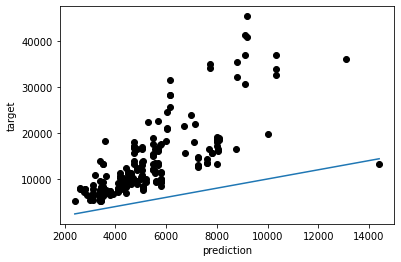

In [18]:
make_calibration_plot(predictions, car_data[LABEL].values)

## Computing the Loss
For now we are using root mean squared error (RMSE) for our loss since that is the appropriate loss to use for linear regression.  However, to keep the procedure to train the model very generic, we will use a method compute loss that can be tailored to other types of problems. For this lab, our implementation will be to return the RMSE.


In [19]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

##Learning Curve

Another important tool is a graph often called a **learning curve** that shows the loss being minimized on the y-axis and the training steps (time) on the x-axis.  Looking at the learning curve will help you understand if you have set the `learning_rate` too high or too low, how many `steps` you need to train and other things that we'll explore later.  

Next we define a method to plot the learning curve given a list of training losses that will be recorded at regular intervals during training.

In [20]:
def plot_learning_curve(training_losses):
  """ Plot the learning curve
  
  Args:
    training_loses: a list of losses to plot
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses)

##Training Our Model

We now have all the pieces we need to train a model.  In order to generate intermediate losses for the learning curve (and record as we are training), we divide the training into 10 periods.  After each period we compute the loss.  We also store the weight and bias of the model at that time so that we can then visually show how the model evolves in a scatter plot.  You are welcome to modify the number of periods but 10 seems to work out pretty well.

In [21]:
def train_model(linear_regressor, steps):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    steps: A non-zero `int`, the total number of training steps.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the loss, slope (feature weight), bias, and a name
  # for the model when there is a single feature (which would then allos us
  # to plot the model in a scatter plot).
  print("Training model...")
  training_losses = []
  slopes = []
  biases = []
  model_names = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    linear_regressor.fit(input_fn=train_input_fn, steps=steps_per_period)

    # Use the predict method to compute the predictions from the current model
    predictions = np.array(list(linear_regressor.predict(
        input_fn=train_input_fn)))
   
    # Compute the loss between the predictions and the correct labels, append
    # the loss to the list of losses used to generate the learning curve after
    # training is complete and print the current loss
    loss = compute_loss(predictions, training_examples[LABEL])
    training_losses.append(loss) 
    print("  Loss after period %02d : %0.3f" % (period, loss))
     
    # When there is a single input feature, add slope, bias and model_name to
    # the lists to be used later to plot the model after each training period.
    if len(NUMERICAL_FEATURES) == 1 and len(CATEGORICAL_FEATURES) == 0:
      feature_weight = fnmatch.filter(linear_regressor.get_variable_names(),
                                      'linear/*/weight')
      slopes.append(linear_regressor.get_variable_value(
          feature_weight[0])[0])
      biases.append(linear_regressor.get_variable_value(
          'linear/bias_weight')[0])
      model_names.append("period_" + str(period))
      
  # Now that training is done print the final loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % loss) 
  
  # Generate a figure with the learning curve on the left and either a scatter
  # plot or calibration plot (when more than 2 input features) on the right
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
 
  if len(NUMERICAL_FEATURES) > 1 or len(CATEGORICAL_FEATURES) != 0:
    plt.title("Calibration Plot")
    make_calibration_plot(predictions, training_examples[LABEL])

  else:
    plt.title("Learned Model by Period on Scatter Plot")
    make_scatter_plot(training_examples, NUMERICAL_FEATURES[0], LABEL,
                      slopes, biases, model_names)
   
  return linear_regressor

### Example learning curve when the learning rate that is too high

When the learning rate is too high you will see the loss going up and down indicating you are making adjustments that are too large.  When you see this happening lower the learning rate (initially by a factor of 10 and then make smaller adjustments when you are close).  In this case you are moving back and forth between having the slope too large and too small.

Training model...
  Loss after period 00 : 41600.715
  Loss after period 01 : 15363.708
  Loss after period 02 : 41600.704
  Loss after period 03 : 15363.706
  Loss after period 04 : 41600.670
  Loss after period 05 : 15363.713
  Loss after period 06 : 41600.659
  Loss after period 07 : 15363.719
  Loss after period 08 : 41600.643
  Loss after period 09 : 15363.705
Final Loss (RMSE) on the training data: 15363.705


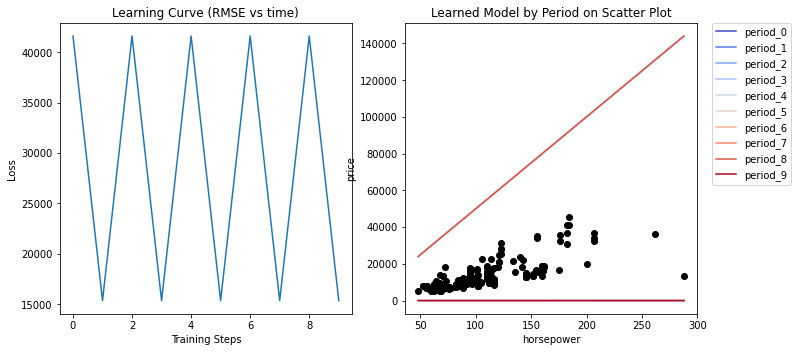

In [22]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"

LEARNING_RATE = 100
STEPS = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

### Example learning curve when the learning rate that is too low

When the learning rate is too low then the changes are too small.  While this might eventually get you to a good solution it would take way more steps than needed and the training time is roughly proportinal to the number of steps so you want to find a learning rate that gets you to a good solution as fast as you can.  You can see for these settings that the model learned (the line you see in the scatter plot) is improving and would eventually get there but is taking much, much longer than needed to train.

Training model...
  Loss after period 00 : 14840.459
  Loss after period 01 : 14319.773
  Loss after period 02 : 13801.919
  Loss after period 03 : 13287.341
  Loss after period 04 : 12776.364
  Loss after period 05 : 12269.416
  Loss after period 06 : 11766.904
  Loss after period 07 : 11269.477
  Loss after period 08 : 10777.928
  Loss after period 09 : 10293.098
Final Loss (RMSE) on the training data: 10293.098


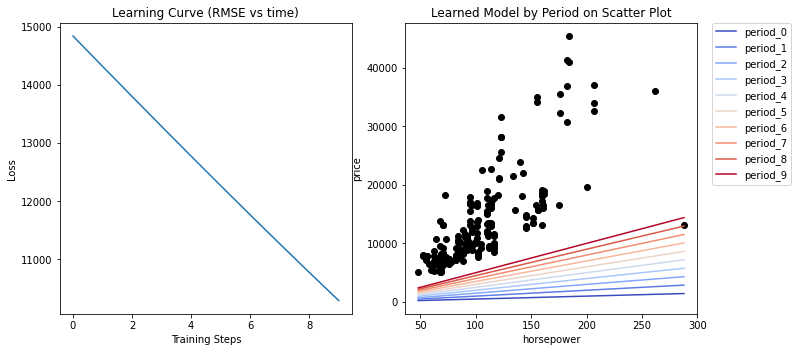

In [23]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"

LEARNING_RATE = 0.001
STEPS = 10000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

##Task 2 - Modify the hyperparmaters to get a better model. (1 Points)
For this task, you can use the code block below that puts all the above code in a single cell for convenience. Focus on first finding a good learning rate and then adjusting the number of steps to be what you need to converge.

**IN ORDER TO GET CREDIT FOR THIS TASK, YOU MUST EDIT THIS TEXT BLOCK STARTING HERE TO ANSWER THESE QUESTIONS. PLEASE DO THIS THROUGHOUT ALL OF THE LABS WHEN ASKED A QUESTION IN A TEXT BOX**

* List at least 3 of the sets of hyperparameters you tried and the RMSE obtained.  Your primary goal is to get the lowest RMSE you can.  Once you've done that a secondary goal is to minmize the number of steps used since the computation cost depends heavily on the number of steps.

* Submit this with the results from the hyperparameters that you feel worked best.

In [24]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"

## Fill in the rest of your solution here.  Feel free to introduce multiple
## code boxes if you want to see the solutions and learning curves from
## different options at the same time

**Put your answers the the given questions in this text box.**

##Task 3: Try a Different Input Feature. (3 Points)

The choice of the hyperparameters depedns a lot on the data set and what you are trying to learn.  In this task you will try to predict the price from highway mpg. In this task you will find a good set of hyperparmeters for this problem.

* Use highway-mpg instead of horsepower to predict price  You might want to start by just plotting the data.  What do you observe?
* What hyperparameters give you the best trained model that you can get.  Try to keep the learning steps as small as you can while still training a good model.
* Did you have to change the hyperparameters a lot?  If you did, why do you think that might be the case?
* How does the RMSE for your model compare to the optimal RMSE?  Think about what you'll need to do in order to answer this question.

In [25]:
NUMERICAL_FEATURES = ["highway-mpg"]
CATEGORICAL_FEATURES = []
LABEL = "price"

## Fill in the rest of your solution here.

**Put your answers the the given questions in this text box.**